<a href="https://colab.research.google.com/github/17092003vamsi/213ECE3317/blob/main/final_shap_code_completed_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6240 - loss: 0.8770 - val_accuracy: 0.5161 - val_loss: 12.9346 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 958ms/step - accuracy: 0.9066 - loss: 0.2720 - val_accuracy: 0.5161 - val_loss: 5.2889 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9123 - loss: 0.2528 - val_accuracy: 0.5161 - val_loss: 3.3554 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9734 - loss: 0.1545 - val_accuracy: 0.5161 - val_loss: 2.5665 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9862 - loss: 0.1214 - val_accuracy: 0.5161 - val_loss: 1.9123 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9975 - loss: 0.0915 - val_accuracy: 0.5161 - val_loss: 1.3329 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9749 - loss: 0.0916 - val_accuracy: 0.5323 - val_

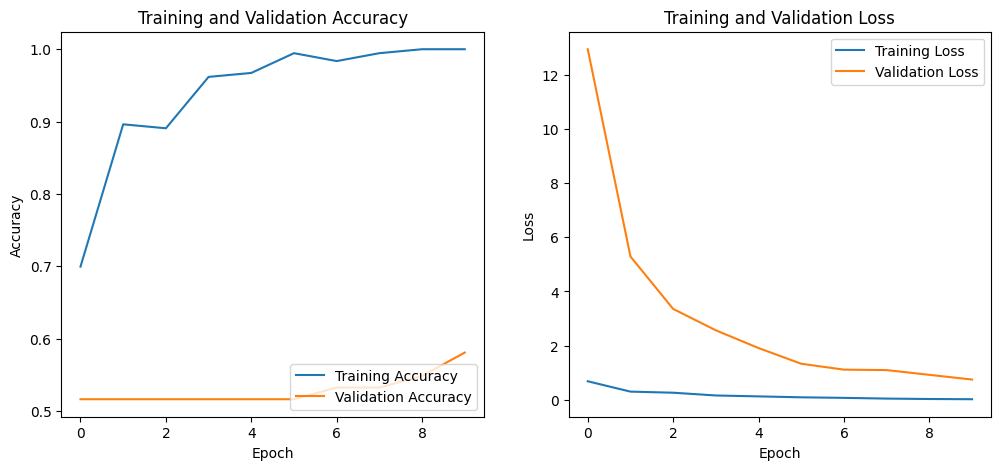

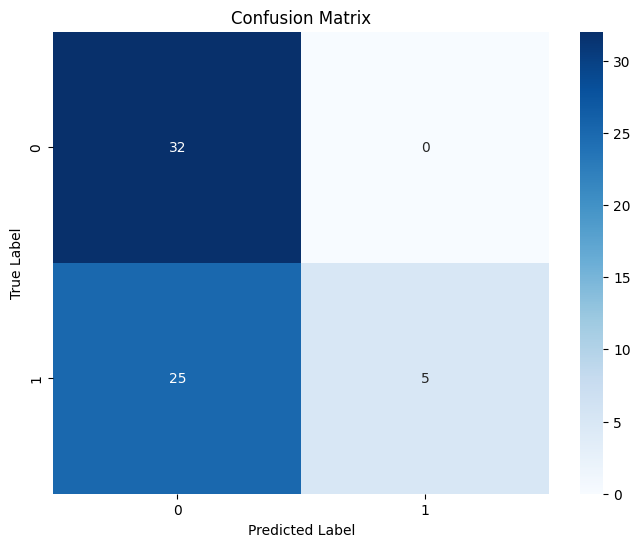

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


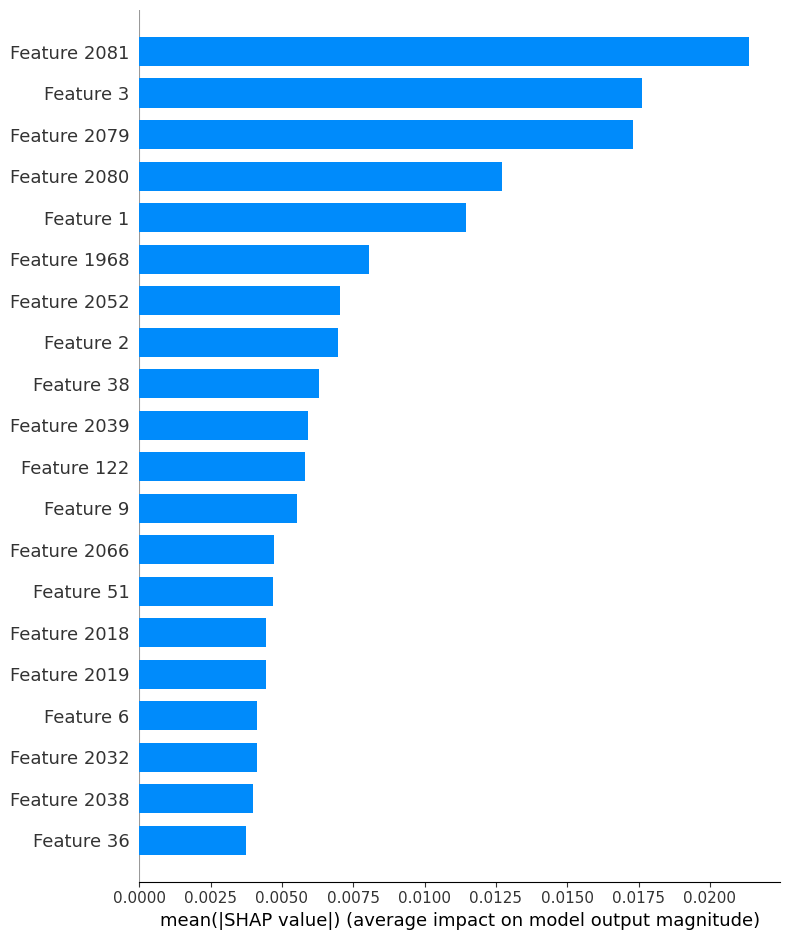

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
!pip install shap
import shap

# Load the dataset
def load_data(file_path):
    data = pd.read_csv('/content/COMPLETE DATA SET 2 (1).csv')
    return data

# Preprocess the data
def preprocess_data(data):
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data['Label'].values)

    # Identify non-numeric columns and apply one-hot encoding
    X = data.drop(columns=['Type', 'Label'])
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns
    X = pd.get_dummies(X, columns=non_numeric_cols)

    # Apply FFT to each signal in the feature matrix
    X = X.values
    X_fft = np.abs(np.array([fft(signal) for signal in X]))

    # Reshape the feature matrix for CNN input
    X_fft = X_fft.reshape((X_fft.shape[0], X_fft.shape[1], 1))

    return X_fft, y, X

# Split the dataset into training, validation, and testing sets
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the CNN model
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model with advanced callbacks
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Generate predictions and confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype("int64")
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return cm

# Visualize results
def plot_results(history, cm):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# SHAP model explainability
def explain_model(model, X_test, original_X):
    # Select a smaller subset of test data for explanation
    subset_size = 100
    X_test_subset = X_test[:subset_size]

    # Ensure the SHAP explainer matches the input shape of the model
    explainer = shap.DeepExplainer(model, X_test_subset)
    shap_values = explainer.shap_values(X_test_subset)

    # Handle the case where shap_values is a list (for multi-output models)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]  # Select the first output's SHAP values

    # Reshape SHAP values to match the original input shape
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)

    # Reshape X_test_subset for compatibility with summary_plot
    X_test_subset_reshaped = X_test_subset.reshape(X_test_subset.shape[0], -1)

    # Plot summary using SHAP mean absolute values
    shap.summary_plot(shap_values_reshaped, original_X[:subset_size], plot_type="bar")

# Main execution
def main():
    file_path = '/content/COMPLETE DATA SET 2 (1).csv'  # Replace with your dataset path
    data = load_data(file_path)

    # Preprocess the data using FFT
    X_fft, y, original_X = preprocess_data(data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_fft, y)

    # Build, train, and evaluate the CNN model
    model = build_model((X_train.shape[1], 1))
    history = train_model(model, X_train, y_train, X_val, y_val)

    cm = evaluate_model(model, X_test, y_test)
    plot_results(history, cm)

    # Explain the model predictions using SHAP
    explain_model(model, X_test, original_X)

# Run the main function
if __name__ == '__main__':
    main()


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.6511 - loss: 0.7210 - val_accuracy: 0.8710 - val_loss: 0.2992
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8484 - loss: 0.2794 - val_accuracy: 0.9839 - val_loss: 0.1912
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9900 - loss: 0.1119 - val_accuracy: 1.0000 - val_loss: 0.1073
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9980 - loss: 0.0455 - val_accuracy: 1.0000 - val_loss: 0.0394
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0222


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Class 0:


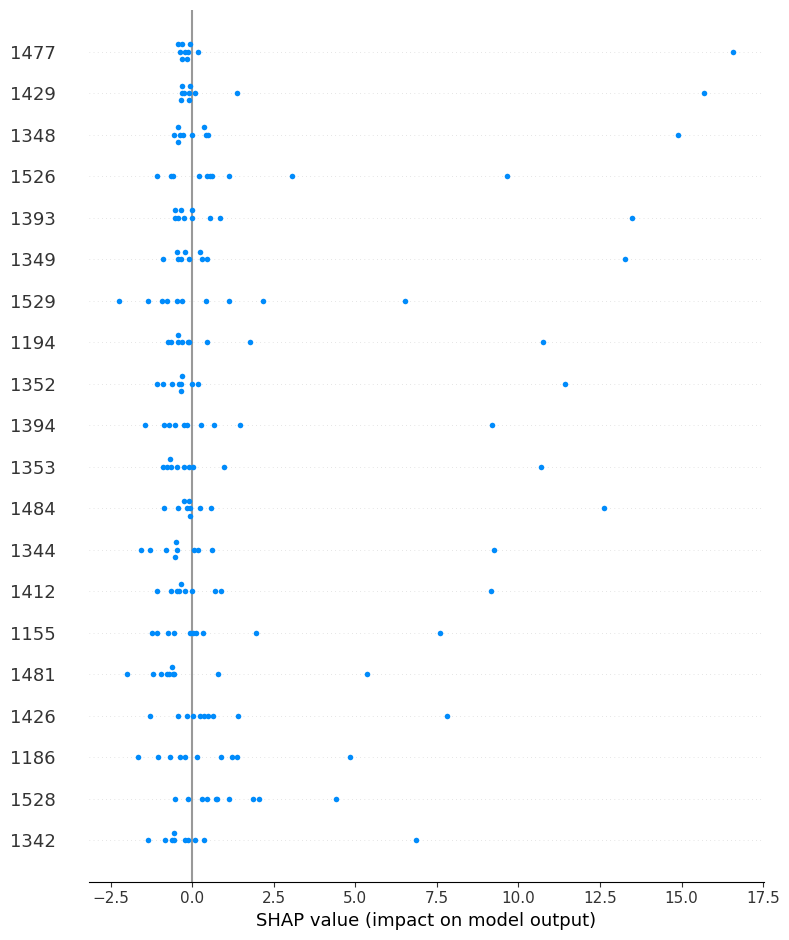

Class 1:


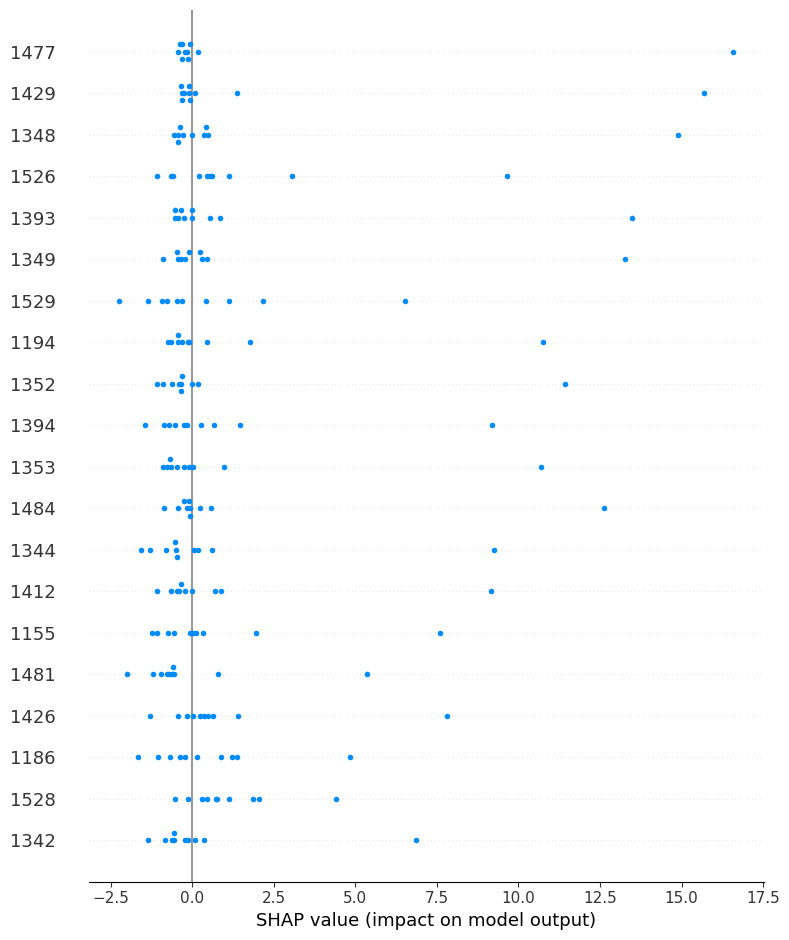

Class 2:


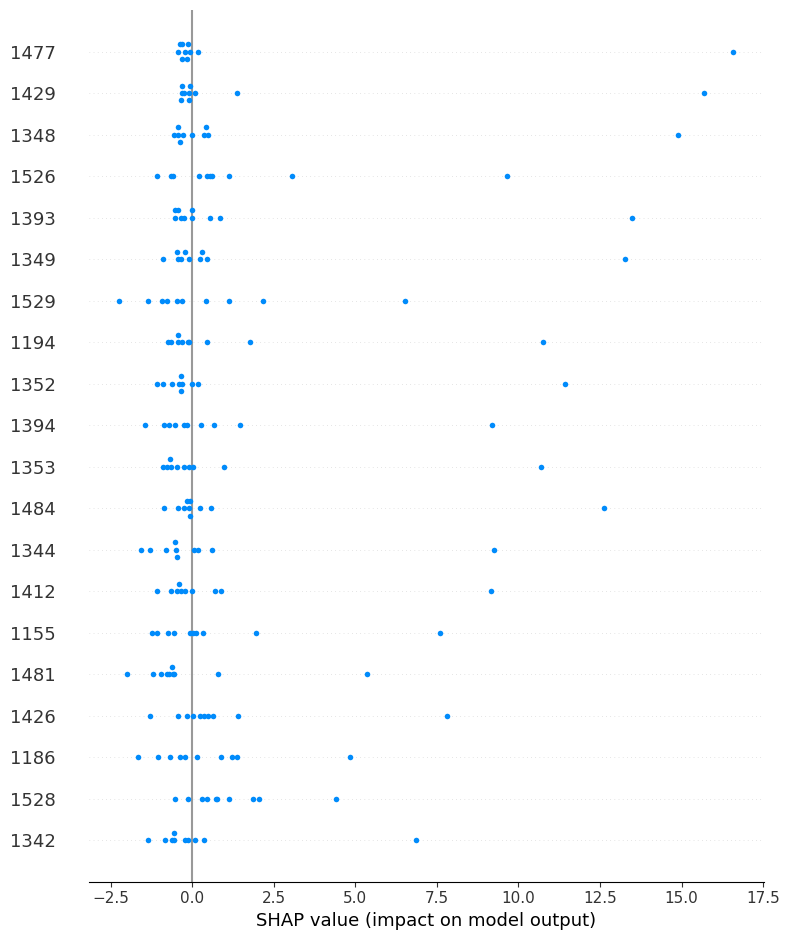

Class 3:


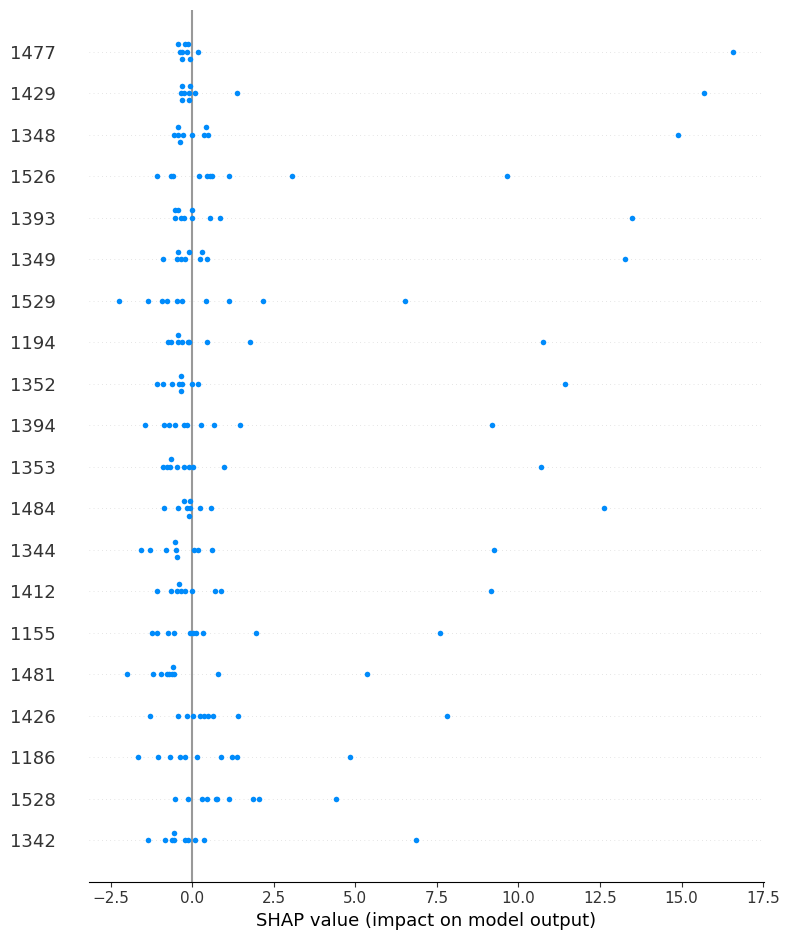

Class 4:


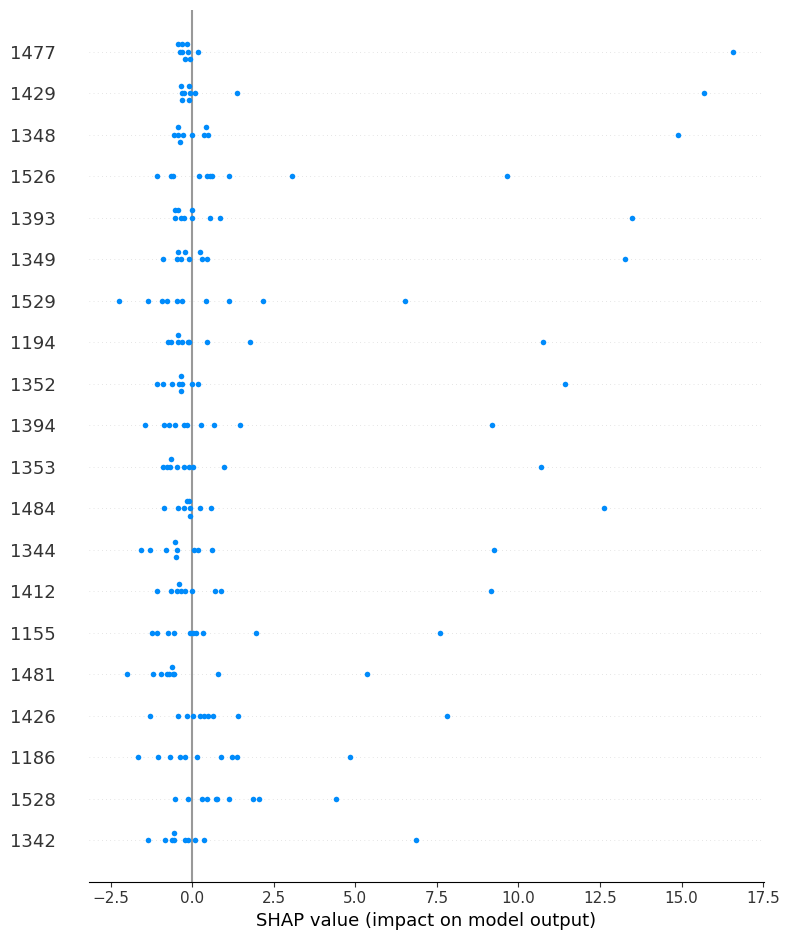

Class 5:


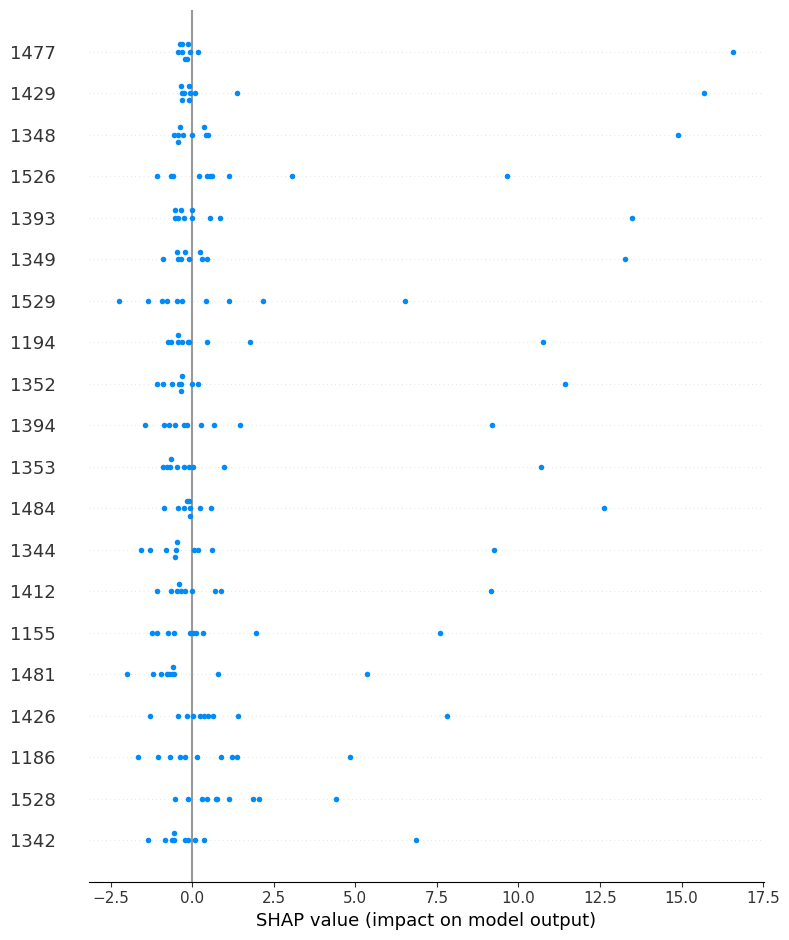

Class 6:


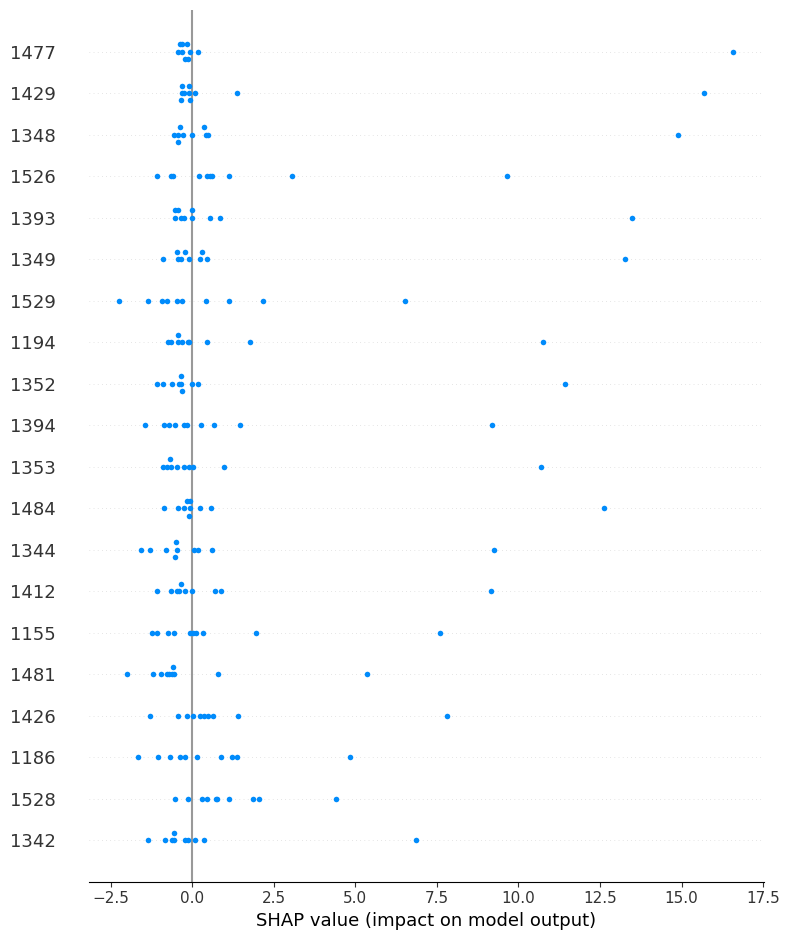

Class 7:


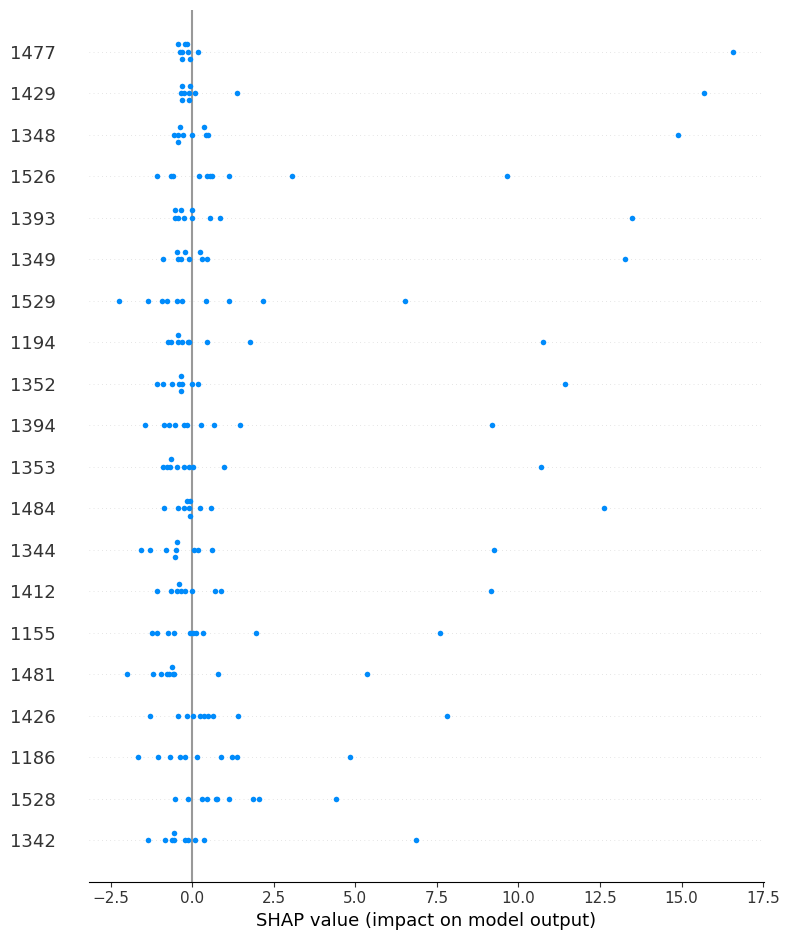

Class 8:


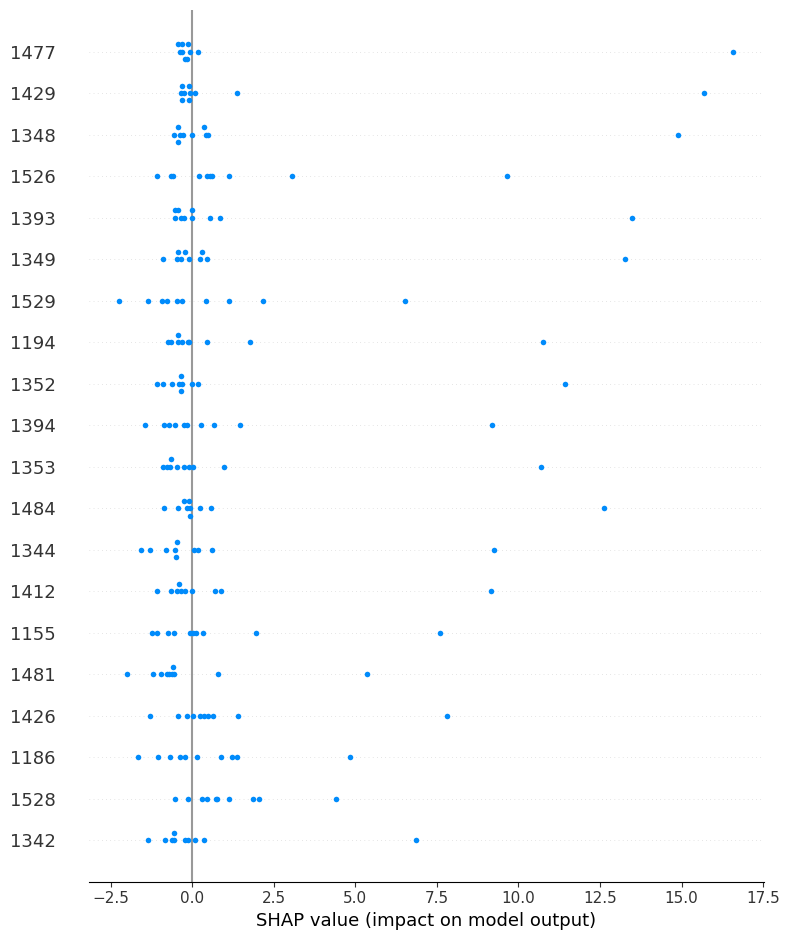

Class 9:


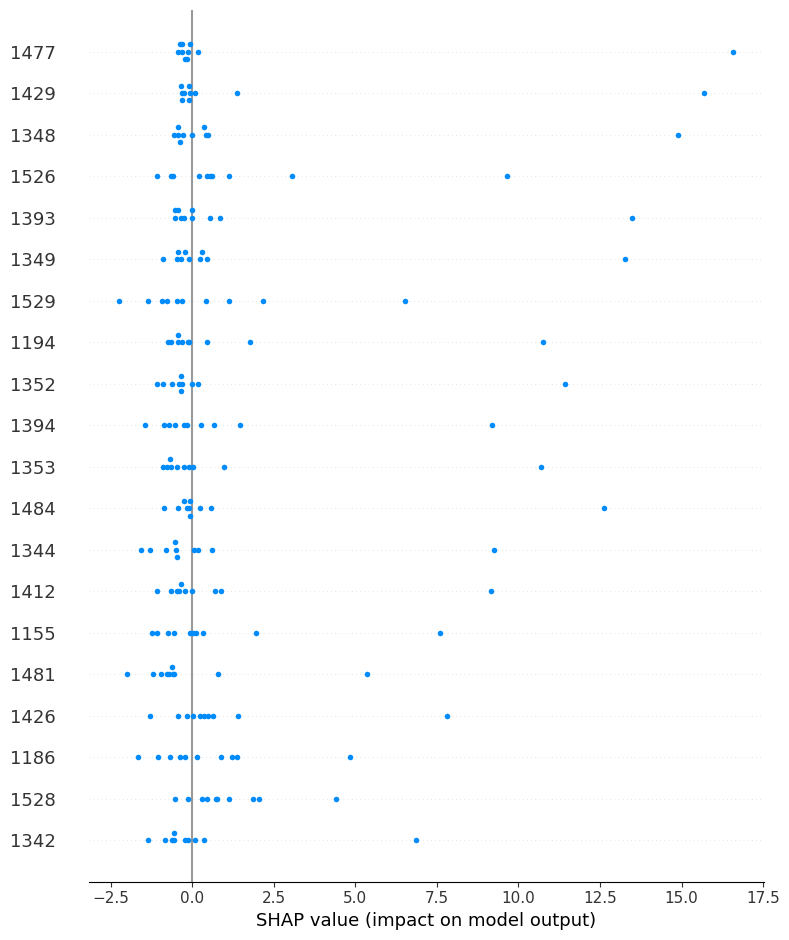

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
!pip install shap
import shap
import matplotlib.pyplot as plt

# Load your dataset
file_path = '/content/COMPLETE DATA SET 2 (1).csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Separate features and labels
X = data.drop(columns=['Type', 'Label'])
y = data['Label']

# Convert labels to numerical using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for CNN (assuming 1D convolution)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_encoded, test_size=0.2, random_state=42)

# Define a simple CNN model
model = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_reshaped.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

 # SHAP explanation
explainer = shap.DeepExplainer(model, X_train[:100])  # Use a subset of the data
shap_values = explainer.shap_values(X_test[:10])

# Reshape X_test back to 2D for SHAP
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1])

# Plot SHAP values for each class
for class_idx in range(len(shap_values)):  # Iterate through each class
    print(f"Class {class_idx}:")
    shap.summary_plot(X_test_reshaped[:10], feature_names=X.columns)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6333 - loss: 0.9145 - val_accuracy: 0.5161 - val_loss: 18.0059 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8563 - loss: 0.2936 - val_accuracy: 0.5161 - val_loss: 8.7432 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 917ms/step - accuracy: 0.9034 - loss: 0.2161 - val_accuracy: 0.5161 - val_loss: 5.7339 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 917ms/step - accuracy: 0.9563 - loss: 0.1442 - val_accuracy: 0.5161 - val_loss: 4.0076 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 985ms/step - accuracy: 0.9592 - loss: 0.1290 - val_accuracy: 0.5161 - val_loss: 2.8467 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9882 - loss: 0.0743 - val_accuracy: 0.5161 - val_loss: 2.2656 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 896ms/step - accuracy: 0.9841 - loss: 0.0741 - val_accuracy: 0.5

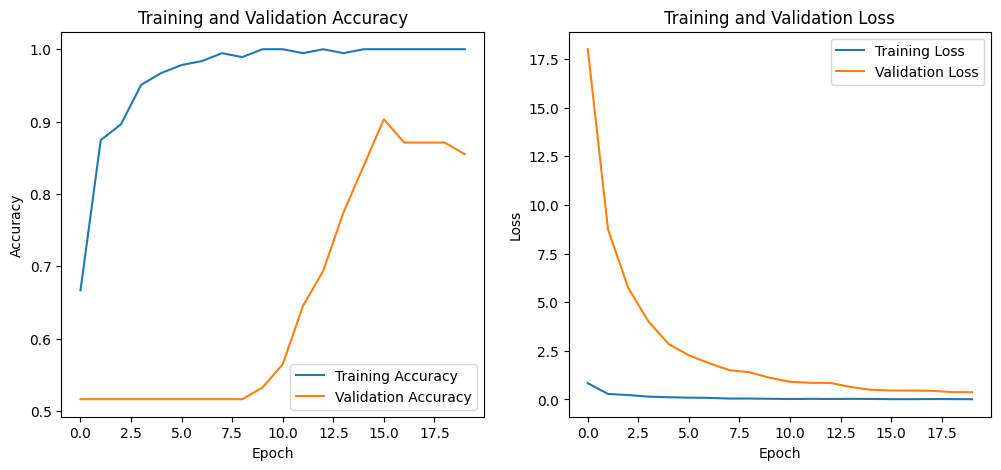

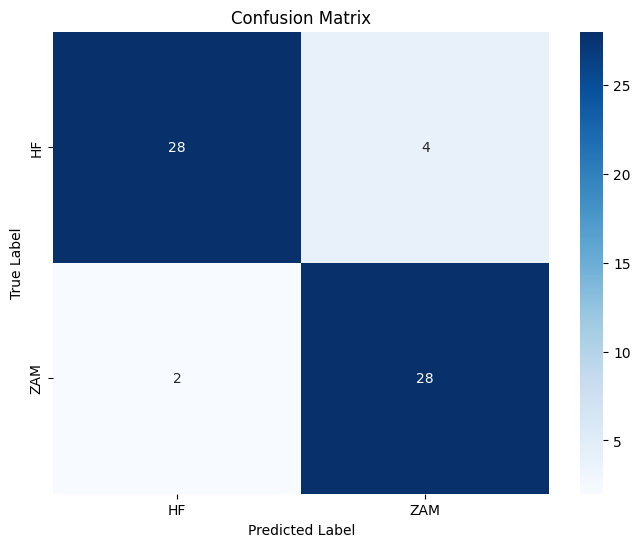

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


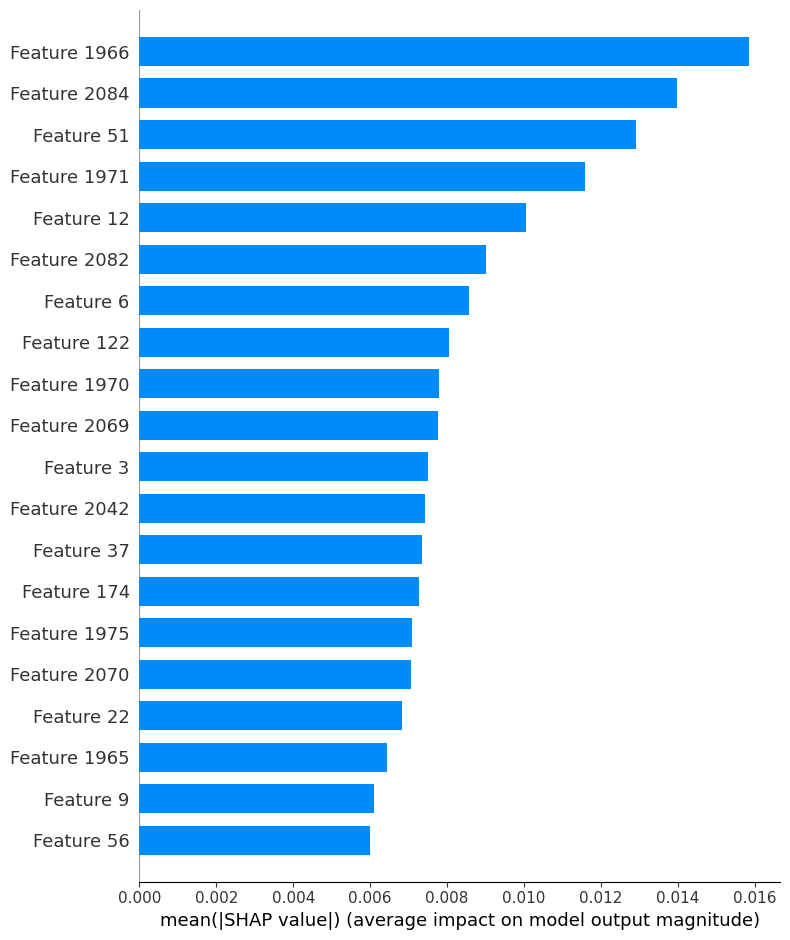

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: ZAM (Tumor Associated Fibroblasts)


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
import shap

# Load the dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Preprocess the data
def preprocess_data(data):
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data.iloc[:, -1].values)

    # Identify non-numeric columns and apply one-hot encoding
    X = data.iloc[:, :-1]
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns
    X = pd.get_dummies(X, columns=non_numeric_cols)

    # Convert to numpy array for FFT
    X = X.values

    # Apply FFT to each signal in the feature matrix
    X_fft = np.abs(np.array([fft(signal) for signal in X]))

    # Reshape the feature matrix for CNN input
    X_fft = X_fft.reshape((X_fft.shape[0], X_fft.shape[1], 1))

    return X_fft, y

# Split the dataset into training, validation, and testing sets
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the CNN model
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the model with advanced callbacks
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Generate predictions and confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype("int64")
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return cm

# Visualize results
def plot_results(history, cm):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HF", "ZAM"], yticklabels=["HF", "ZAM"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# SHAP model explainability
def explain_model(model, X_test):
    # Select a smaller subset of test data for explanation
    subset_size = 100
    X_test_subset = X_test[:subset_size]

    # Ensure the SHAP explainer matches the input shape of the model
    explainer = shap.DeepExplainer(model, X_test_subset)
    shap_values = explainer.shap_values(X_test_subset)

    # Handle the case where shap_values is a list (for multi-output models)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]  # Select the first output's SHAP values

    # Reshape SHAP values to match the original input shape
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)

    # Reshape X_test_subset for compatibility with summary_plot
    X_test_subset_reshaped = X_test_subset.reshape(X_test_subset.shape[0], -1)

    # Plot summary using SHAP mean absolute values
    shap.summary_plot(shap_values_reshaped, X_test_subset_reshaped, plot_type="bar")

# Main execution
def main():
    file_path = 'COMPLETE DATA SET 2 (1).csv'  # Path to the dataset
    data = load_data(file_path)
    X, y = preprocess_data(data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    model = build_model((X_train.shape[1], 1))
    history = train_model(model, X_train, y_train, X_val, y_val)

    cm = evaluate_model(model, X_test, y_test)
    plot_results(history, cm)

    explain_model(model, X_test)

    # Predict on a new signal from the validation set
    new_signal = X_val[0].reshape(1, -1, 1)
    prediction = model.predict(new_signal)
    predicted_class = "HF (Normal Skin Fibroblasts)" if prediction < 0.5 else "ZAM (Tumor Associated Fibroblasts)"
    print(f"Predicted class: {predicted_class}")

# Run the main function
main()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5764 - loss: 1.0688 - val_accuracy: 0.5161 - val_loss: 17.3165 - learning_rate: 0.0010
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8285 - loss: 0.3626 - val_accuracy: 0.5161 - val_loss: 7.9079 - learning_rate: 0.0010
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8706 - loss: 0.3044 - val_accuracy: 0.5161 - val_loss: 5.7451 - learning_rate: 0.0010
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9310 - loss: 0.2155 - val_accuracy: 0.5161 - val_loss: 4.1709 - learning_rate: 0.0010
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 914ms/step - accuracy: 0.9493 - loss: 0.1712 - val_accuracy: 0.5161 - val_loss: 3.0867 - learning_rate: 0.0010
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 906ms/step - accuracy: 0.9473 - loss: 0.1874 - val_accuracy: 0.5161 - val_loss: 2.2434 - learning_rate: 0.0010
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1000ms/step - accuracy: 0.9858 - loss: 0.0984 - val_accuracy: 0.5161 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.96      0.77      0.85        30

    accuracy                           0.87        62
   macro avg       0.89      0.87      0.87        62
weighted avg       0.88      0.87      0.87        62



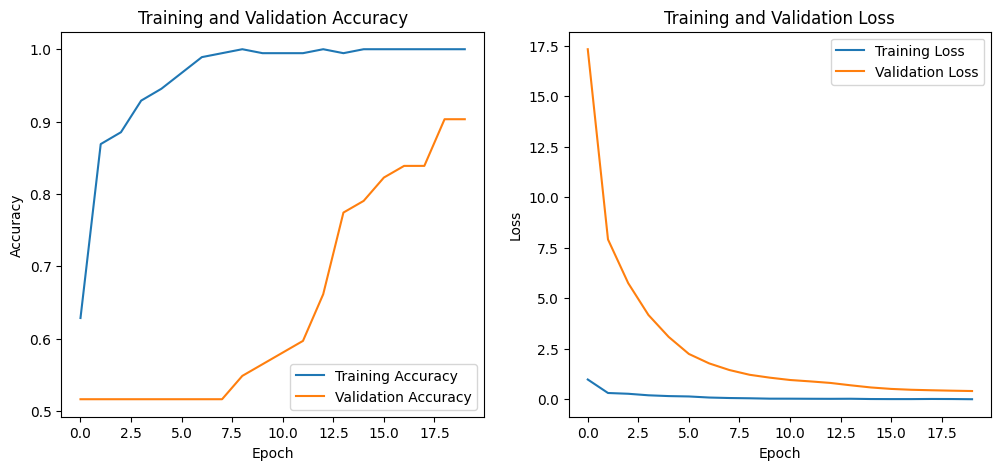

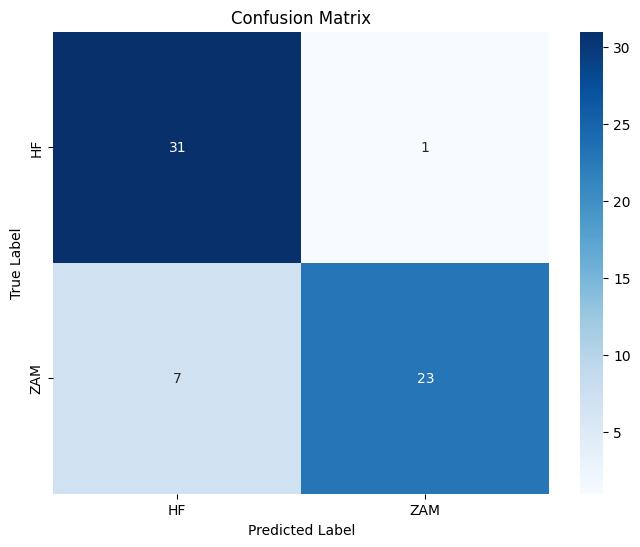

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


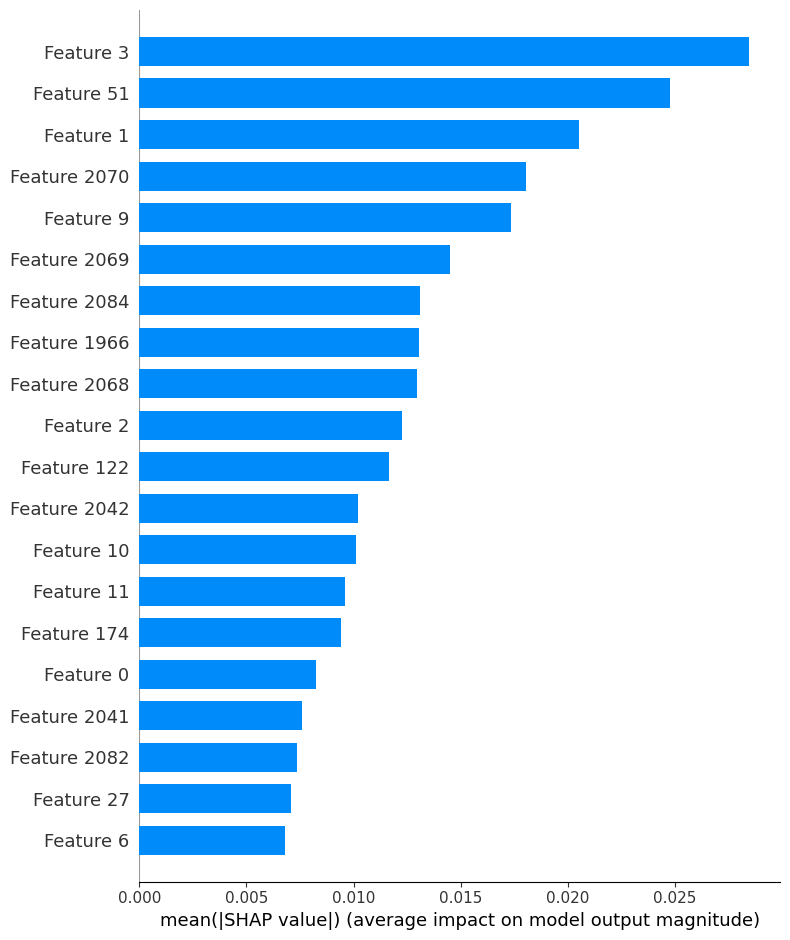

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class: HF (Normal Skin Fibroblasts)


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
!pip install shap
import shap

# Load the dataset
def load_data(file_path):
    data = pd.read_csv('/content/COMPLETE DATA SET 2 (1).csv')
    return data

# Preprocess the data
def preprocess_data(data):
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data.iloc[:, -1].values)

    # Identify non-numeric columns and apply one-hot encoding
    X = data.iloc[:, :-1]
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns
    X = pd.get_dummies(X, columns=non_numeric_cols)

    # Convert to numpy array for FFT
    X = X.values

    # Apply FFT to each signal in the feature matrix
    X_fft = np.abs(np.array([fft(signal) for signal in X]))

    # Reshape the feature matrix for CNN input
    X_fft = X_fft.reshape((X_fft.shape[0], X_fft.shape[1], 1))

    return X_fft, y

# Split the dataset into training, validation, and testing sets
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the CNN model
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train the model with advanced callbacks
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Generate predictions and confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype("int64")
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return cm

# Visualize results
def plot_results(history, cm):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HF", "ZAM"], yticklabels=["HF", "ZAM"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# SHAP model explainability
def explain_model(model, X_test):
    # Select a smaller subset of test data for explanation
    subset_size = 100
    X_test_subset = X_test[:subset_size]

    # Ensure the SHAP explainer matches the input shape of the model
    explainer = shap.DeepExplainer(model, X_test_subset)
    shap_values = explainer.shap_values(X_test_subset)

    # Handle the case where shap_values is a list (for multi-output models)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]  # Select the first output's SHAP values

    # Reshape SHAP values to match the original input shape
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)

    # Reshape X_test_subset for compatibility with summary_plot
    X_test_subset_reshaped = X_test_subset.reshape(X_test_subset.shape[0], -1)

    # Plot summary using SHAP mean absolute values
    shap.summary_plot(shap_values_reshaped, X_test_subset_reshaped, plot_type="bar")

# Main execution
def main():
    file_path = 'COMPLETE DATA SET 2 (1).csv'  # Path to the dataset
    data = load_data(file_path)
    X_fft, y = preprocess_data(data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_fft, y)

    model = build_model((X_train.shape[1], 1))
    history = train_model(model, X_train, y_train, X_val, y_val)

    cm = evaluate_model(model, X_test, y_test)
    plot_results(history, cm)

    explain_model(model, X_test)

    # Predict on a new signal from the validation set
    new_signal = X_val[0].reshape(1, -1, 1)
    prediction = model.predict(new_signal)
    predicted_class = "HF (Normal Skin Fibroblasts)" if prediction < 0.5 else "ZAM (Tumor Associated Fibroblasts)"
    print(f"Predicted class: {predicted_class}")

# Run the main function
if __name__ == '__main__':
    main()
